In [1]:
import pandas as pd
import h5py
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import gc
import random
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os

import utils_pre_post as u

In [2]:
#This is to avoid conflicts between torch and matplotlib. This happens in Laura's pc, maybe not in yours.
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
print(torch.cuda.is_available())
if torch.cuda.is_available():  
    dev = "cuda" 
    map_location=None
else:  
    dev = "cpu"  
    map_location='cpu'
device = torch.device(dev)

True


In [4]:
path=os.getcwd()+'\\'
print("path: ",path)

path:  c:\Users\Laura\Desktop\Laura\Istruzione\PhD\Datasets_and_related_experiments\Norcia\dataset\


In [5]:
preprocessing=False # this is True only the firse time, then it is no more needed
plot_model_hidden=False # Set True to visualize hidden states plots, during test
save_results=False
train=False
evaluation=True
dataToProcess="T1212" # "mini" or "all" or single station (e.g. "T1213" or "NRCA"...)
mdl= "CNN" # "FCN" or "FCN_saliency" or "CNN" or "CNN_saliency"
num_classes=2
save_img_out=False

if preprocessing:
    when="post" # data to preprocess: "pre" if you want to process pre data (label= [1, 0]), 
                # "post" if you want post data (label= [0, 1]), "visso" if you want data between 
                # Visso EQ (Mw 5.9, October 26th 2016) and Norcia EQ (Mw 6.5, October 30th 2016) (label= [0, 0])
if mdl== "CNN":
  plot_model_hidden=False #this forces plot_model_hidden to be false in the case of CNN, because this is not implemented
if save_results or evaluation:
  seed=1234
  u.seed_everything(seed)

Setting seeds


In [6]:
traces_in_test="jan_aug_2017" # traces to be forced in test set: "NO" or "similar_events" or "NRCA_2000To2022" or "jan_aug_2017"
# force_traces_in_test will be a list of events for testing the model
if traces_in_test=="NO":
    force_traces_in_test=[]#['NRCA.IV.100758332_EV','NRCA.IV.100401915_EV'] #
# this is to test on similar events, still using NRCA station
elif traces_in_test=="similar_events":
    df_selected_traces = pd.read_pickle(path+'dataframe\\dataframe_NRCA_SelectedSimilarTraces.csv')#path+'dataframe\\dataframe_NRCA_SelectedSimilarTraces.csv')
    df_selected_traces=df_selected_traces.sort_values(by=['associato_ev']) # in this way similar events will be consecutive in the df
    force_traces_in_test=df_selected_traces["trace_name"].values.tolist()#[]#'NRCA.IV.100758332_EV','NRCA.IV.100401915_EV'] #traces to be forced in test set
# this is to test generalizability: we still use NRCA station but using events from 2000 to 2016 and from 2017 to 2022
elif traces_in_test=="NRCA_2000To2022" or traces_in_test=="jan_aug_2017":
    # since traces are not in the original df for training, this will be done later, as a separate test set
    force_traces_in_test=[]


## Preprocessing

In [8]:
if preprocessing:
    u.DataPreprocessing(path, dataToProcess, when)

## ML

In [9]:
if mdl=="FCN_saliency" or mdl=="CNN_saliency":# for saliency visualization:
    dev = "cpu"  
    map_location='cpu'
    device = torch.device(dev)

In [10]:
stations=["FDMO","NRCA","T1212","T1213","T1216","MC2","MMO1","T1214","T1244"]
df_empty = pd.DataFrame(columns = ['E_channel', 'N_channel', 'Z_channel', 'trace_name', 'label',
       'trace_start_time', 'network_code', 'receiver_name', 'receiver_type',
       'receiver_elevation_m', 'receiver_latitude', 'receiver_longitude',
       'source_id', 'source_depth_km', 'source_latitude', 'source_longitude',
       'source_magnitude_type', 'source_magnitude', 'source_origin_time', 'p_travel_sec'])
df_pre = df_empty.copy() 
df_visso = df_empty.copy() # if num_classes!=9 this df will remain empty
df_post = df_empty.copy()

if dataToProcess=="all": # "FDMO","NRCA","T1212","T1213","T1216","MC2","MMO1","T1214","T1244"
    for station in stations:
        #check if its better to make df preual length as here, or in another way such that we don't waste a lot of data 
        df_preStation = pd.read_pickle(path+'dataframe\\dataframe_pre_'+station+'.csv')
        if num_classes==9:
            df_vissoStation = pd.read_pickle(path+'dataframe\\dataframe_visso_'+station+'.csv')
        else:
            df_vissoStation = df_empty.copy()
        df_postStation = pd.read_pickle(path+'dataframe\\dataframe_post_'+station+'.csv')
        df_preStation, df_vissoStation, df_postStation=u.pre_post_equal_length(df_preStation, df_vissoStation, df_postStation,force_traces_in_test, num_classes)
        df_pre=pd.concat([df_pre, df_preStation], ignore_index=True)
        df_visso=pd.concat([df_visso, df_vissoStation], ignore_index=True)
        df_post=pd.concat([df_post, df_postStation], ignore_index=True)
else:
    df_pre = pd.read_pickle(path+'dataframe\\dataframe_pre_'+dataToProcess+'.csv')
    df_post = pd.read_pickle(path+'dataframe\\dataframe_post_'+dataToProcess+'.csv')
    if num_classes==9:
        df_visso = pd.read_pickle(path+'dataframe\\dataframe_visso_'+dataToProcess+'.csv')
    df_pre, df_visso, df_post=u.pre_post_equal_length(df_pre, df_visso, df_post,force_traces_in_test, num_classes)
    
for i in force_traces_in_test:
    if (i not in df_pre['trace_name'].values) and (i not in df_visso['trace_name'].values) and (i not in df_post['trace_name'].values):
        print("WARNING: ", i," not in df_pre and df_post. This will cause an error.")
df_pre['trace_start_time'] = df_pre['trace_start_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df_visso['trace_start_time'] = df_visso['trace_start_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df_post['trace_start_time'] = df_post['trace_start_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

In [11]:
if num_classes==2:
    df=pd.concat([df_pre, df_post], ignore_index=True)
else:
    frames_pre = u.frames_N_classes(df_pre,num_classes, pre_or_post="pre")
    frames_post = u.frames_N_classes(df_post,num_classes, pre_or_post="post")
    if num_classes==9:
        frames_visso = u.frames_N_classes(df_visso,num_classes, pre_or_post="visso")
        df=pd.concat([pd.concat(frames_pre),pd.concat(frames_visso),pd.concat(frames_post)], ignore_index=True)
    else:
        df=pd.concat([pd.concat(frames_pre),pd.concat(frames_post)], ignore_index=True)

In [12]:
df['source_origin_time'] = df['source_origin_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
df['TTF'] = df.apply (lambda row: u.add_TTF_in_sec(row), axis=1)
df

,E_channel,N_channel,Z_channel,trace_name,label,trace_start_time,network_code,receiver_name,receiver_type,receiver_elevation_m,...,receiver_longitude,source_id,source_depth_km,source_latitude,source_longitude,source_magnitude_type,source_magnitude,source_origin_time,p_travel_sec,TTF
0,"[27.241280234942973, -7.9707563250656035, -3.4...","[2.5345439359609614, 7.810670202950797, 5.2533...","[-9.669316834563828, -6.558247204078167, -7.23...",T1212.IV.100132446_EV,"[1, 0]",2016-10-09 21:43:31.890,IV,T1212,EH,869,...,13.044636,100132446,5.797,42.81422,13.16854,Mw,2.37,2016-10-09 21:43:34,2.89,-1763803.0
1,"[-61.969270794733, -35.21351335890281, 27.6525...","[-11.587950877061726, -33.38932388287639, -14....","[19.841221815492133, 9.61723717572626, -15.595...",T1212.IV.100603122_EV,"[1, 0]",2016-08-26 03:44:18.260,IV,T1212,EH,869,...,13.044636,100603122,6.983,42.83545,13.16688,Mw,1.34,2016-08-26 03:44:20,3.26,-5630157.0
2,"[-13.31424415830708, -16.163611930880464, -15....","[3.379596170985975, 7.212694092482074, 4.67087...","[6.371371745417322, 7.626257687243358, 4.20570...",T1212.IV.100685582_EV,"[1, 0]",2016-09-17 01:11:32.990,IV,T1212,EH,869,...,13.044636,100685582,6.342,42.81619,13.17055,Mw,0.64,2016-09-17 01:11:35,2.99,-3738522.0
3,"[2.7115521581443205, -1.6980957421947225, -1.6...","[2.0562469690719056, -3.7965880719291962, -7.5...","[1.4765381212555184, 6.322110236535933, 3.5341...",T1212.IV.100750216_EV,"[1, 0]",2016-09-03 13:23:58.780,IV,T1212,EH,869,...,13.044636,100750216,4.514,42.82579,13.15546,Mw,0.77,2016-09-03 13:24:01,2.78,-4904176.0
4,"[0.9669297361355487, 0.4762104652079018, -0.04...","[-1.1071794245241988, -2.142726218772341, -2.2...","[0.7384455669464315, -3.126878058429634, -2.24...",T1212.IV.100048429_EV,"[1, 0]",2016-10-23 03:18:18.090,IV,T1212,EH,869,...,13.044636,100048429,5.458,42.84693,13.14626,Mw,1.01,2016-10-23 03:18:20,3.09,-620517.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9265,"[-3.659258615156543, -4.120566385077287, -2.72...","[-0.7512276009967533, -3.3485120202898693, -10...","[6.489573752350125, 7.585748288609299, 2.04555...",T1212.IV.100516153_EV,"[0, 1]",2016-12-27 15:33:11.060,IV,T1212,EH,869,...,13.044636,100516153,4.200,42.84620,13.15317,Mw,0.96,2016-12-27 15:33:13,3.06,5039576.0
9266,"[-25.493129603411045, -19.80267493548326, 2.01...","[0.6593902513883934, -8.48809850480979, -7.484...","[-3.591082103284517, 4.48364716019868, 7.63069...",T1212.IV.100518015_EV,"[0, 1]",2016-12-27 23:36:17.140,IV,T1212,EH,869,...,13.044636,100518015,5.930,42.95794,13.10213,Mw,1.07,2016-12-27 23:36:17,5.14,5068560.0
9267,"[-170.1241649989533, -173.91430652315674, -129...","[53.8824047097836, 77.26117679508361, 79.63878...","[19.952494696159775, 36.864407416371435, 52.43...",T1212.IV.100363018_EV,"[0, 1]",2016-11-07 04:42:55.210,IV,T1212,EH,869,...,13.044636,100363018,2.314,42.87822,13.10498,Mw,2.13,2016-11-07 04:42:57,3.21,680560.0
9268,"[-0.5032461416374299, -4.28077346319045, -2.74...","[-9.996441318057268, -2.715548905700139, -2.31...","[1.7479522417201916, -0.07892059819947016, 0.8...",T1212.IV.100330613_EV,"[0, 1]",2016-11-30 20:26:28.130,IV,T1212,EH,869,...,13.044636,100330613,7.646,42.90474,13.10995,Mw,1.74,2016-11-30 20:26:29,4.13,2724372.0


In [13]:
# df_sorted=df.sort_values(by=['TTF'])
# plt.figure(figsize=(10,5))
# plt.plot(df_sorted['source_origin_time'],abs(df_sorted['TTF']))
# plt.xlabel('Source_origin_tim')
# plt.ylabel('TTF')
# plt.show()

first event in pre is on  2016-08-24 11:06:46.640000  last event in pre is on  2016-10-26 14:49:10.030000
first event in post is on  2016-10-30 07:57:52.440000  last event in post is on  2016-12-31 07:26:48.400000


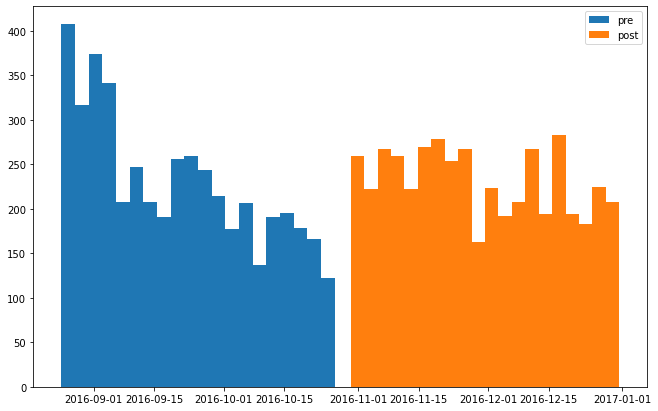

In [14]:
if num_classes==2:
    print("first event in pre is on ",df_pre['trace_start_time'].min()," last event in pre is on ",df_pre['trace_start_time'].max())
    print("first event in post is on ",df_post['trace_start_time'].min()," last event in post is on ",df_post['trace_start_time'].max())

    plt.figure(figsize=(11,7))
    plt.hist(df_pre['trace_start_time'], label='pre', bins=20)
    plt.hist(df_post['trace_start_time'], label='post', bins=20)
    plt.legend(loc='upper right')
    plt.show()
    
    
else: 
    plt.figure(figsize=(11,7))
    c=1
    for f in frames_pre:    
        print("first event in pre",c," is on ",f['trace_start_time'].min()," last event in pre",c," is on ",f['trace_start_time'].max())
        plt.hist(f['trace_start_time'], label='pre'+str(c), bins=20)
        print("label: ",f['label'][0])
        c=c+1
    if num_classes==9:
        c=1
        for f in frames_visso:
            print("first event in visso",c," is on ",f['trace_start_time'].min()," last event in visso",c," is on ",f['trace_start_time'].max())
            plt.hist(f['trace_start_time'], label='visso'+str(c), bins=20)
            print("label: ",f['label'][0])
            c=c+1
    c=1
    for f in frames_post:
        print("first event in post",c," is on ",f['trace_start_time'].min()," last event in post",c," is on ",f['trace_start_time'].max())
        plt.hist(f['trace_start_time'], label='post'+str(c), bins=20)
        print("label: ",f['label'][0])
        c=c+1

    plt.legend(loc='upper right')
    plt.show()

In [15]:
# df = df[(df['source_magnitude'] >= 0.7) & (df['source_magnitude'] <= 2)]
# df = df.reset_index(drop=True)
# df


Events in train dataset:  6489
Events in validation dataset:  926
Events in test dataset:  1855
X_train.shape:  (6489, 2500, 3)
y_train.shape:  (6489, 2)
index_train.shape:  (6489, 1)
X_val.shape:  (926, 2500, 3)
y_val.shape:  (926, 2)
index_val.shape:  (926, 1)
X_test.shape:  (1855, 2500, 3)
y_test.shape:  (1855, 2)
index_test.shape:  (1855, 1)


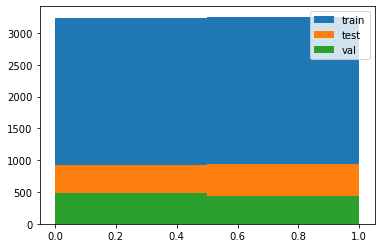

In [16]:
df, X_train, y_train, index_train, X_val, y_val, index_val, X_test, y_test, index_test=u.train_val_test_split(df, train_percentage=0.70, val_percentage=0.10, test_percentage=0.20,force_in_test=force_traces_in_test)

In [17]:
batch_size = 32
tr_dl = u.create_dataloader(X=X_train, y=y_train, index=index_train,target_dataset="train_dataset", batch_size=batch_size)
val_dl = u.create_dataloader(X=X_val, y=y_val, index=index_val,target_dataset="val_dataset", batch_size=batch_size)
test_dl = u.create_dataloader(X=X_test, y=y_test, index=index_test,target_dataset="test_dataset", batch_size=batch_size)

In [18]:
if train:
  loss_function = nn.CrossEntropyLoss()
  min_loss = np.Inf
  loss_history_tr = []
  loss_history_val = []
  loss_history_te = []
  if mdl=="FCN" or mdl=="FCN_saliency":
      num_epochs = 100
      learning_rate = 0.00001
  elif mdl=="CNN" or mdl=="CNN_saliency":
      num_epochs = 50
      learning_rate = 0.001
  init_lr = learning_rate
  lr_decay = 0.99

  inp_size=X_train.shape[1]
  out_size=y_train.shape[1]
  if mdl=="FCN":
    model = u.FCN(num_feature=inp_size, num_class=out_size).to(device)
  if mdl=="FCN_saliency":
    model = u.FCN_for_saliency(num_feature=inp_size, num_class=out_size).to(device)
  elif mdl=="CNN" or mdl=="CNN_saliency":
    s_max=True #if True it add a softmax layer before the output
    model=u.CNN(num_feature=inp_size, num_class=out_size).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
  best_model=type(model)(num_feature=inp_size, num_class=out_size).to(device)

In [19]:
if train:
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("model "+mdl+", pytorch_total_params: "+str(pytorch_total_params)+", pytorch_total_trainable_params: "+str(pytorch_total_trainable_params))

In [20]:
# mmax=0
# mmin=10000
if train:
  for epoch in range(num_epochs):
    model.train()
    sum_loss_tr = 0
    
    for idx, batch in tqdm(enumerate(tr_dl), total=len(tr_dl)):#enumerate(tr_dl):
        model.zero_grad() 
        inp = batch[0].to(device)
        # if inp.max()>mmax:
        #   mmax=inp.max()
        #   print("max",mmax)
        # if inp.min()<mmin:
        #   mmin=inp.min()
        #   print("min",mmin)
        inp=inp[:,0:inp_size,:]
        label = batch[1].to(device)
        if mdl=="FCN":
          output = model(inp.float(), batch_size=batch_size, steps_in=inp_size)[0]
          output=output.sum(dim=1)
        elif mdl=="FCN_saliency":
          output = model(inp.float(), batch_size=batch_size, steps_in=inp_size)
        elif mdl=="CNN" or mdl=="CNN_saliency":
          output = model(inp.float(), batch_size=batch_size, steps_in=inp_size, softmax=s_max)[0]
        
        current_loss = loss_function(output, label)
        current_loss.backward()
        optimizer.step()
        sum_loss_tr += current_loss.item()*batch_size

    curr_tr_loss = sum_loss_tr/len(tr_dl)
    loss_history_tr.append(curr_tr_loss)
    
    model.eval()
    with torch.no_grad():
        sum_loss_val = 0

        for idx, batch in tqdm(enumerate(val_dl), total=len(val_dl)):#enumerate(val_dl):
            inp = batch[0].to(device)
            inp=inp[:,0:inp_size,:]
            label = batch[1].to(device)
            if mdl=="FCN":
              output = model(inp.float(), batch_size=batch_size, steps_in=inp_size)[0]
              output=output.sum(dim=1)
            elif mdl=="FCN_saliency":
              output = model(inp.float(), batch_size=batch_size, steps_in=inp_size)
            elif mdl=="CNN" or mdl=="CNN_saliency":
              output = model(inp.float(), batch_size=batch_size, steps_in=inp_size, softmax=s_max)[0]

            sum_loss_val += loss_function(output, label).item()*batch_size
  
        curr_val_loss = sum_loss_val/len(val_dl)
        loss_history_val.append(curr_val_loss)

        if curr_val_loss < min_loss:
            min_loss = curr_val_loss
            del best_model
            best_model = type(model)(num_feature=inp_size, num_class=out_size)
            best_model.load_state_dict(model.state_dict())
            # if save_model:
            #    torch.save(best_model.state_dict(), path+"target_class"+target_class+"_bestmodel.pt")
            print("Best Epoch:", epoch+1)
    
    model.eval()
    with torch.no_grad():

        sum_loss_te = 0 
        for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)):#enumerate(test_dl):
            inp = batch[0].to(device)
            inp=inp[:,0:inp_size,:]
            label = batch[1].to(device)
            if mdl=="FCN":
              output = model(inp.float(), batch_size=batch_size, steps_in=inp_size)[0]
              output=output.sum(dim=1)
            elif mdl=="FCN_saliency":
              output = model(inp.float(), batch_size=batch_size, steps_in=inp_size)
            elif mdl=="CNN" or mdl=="CNN_saliency":
              output = model(inp.float(), batch_size=batch_size, steps_in=inp_size, softmax=s_max)[0]
            sum_loss_te += loss_function(output, label).item()*batch_size
        
        curr_te_loss = sum_loss_te/len(test_dl)
        loss_history_te.append(curr_te_loss)
        
    print("Epoch", epoch+1, "\tTrain Loss:", curr_tr_loss, "\tValid Loss:", curr_val_loss, "\tTest Loss:", curr_te_loss)

In [21]:
if save_results:
    print("Saving best model...")
    if force_traces_in_test: #some trace to be forced in test
        print("... where some trace are forced in test")
        torch.save(best_model.state_dict(), path+"\\models\\"+dataToProcess+"_bestmodel_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+"_traceForcedInTest.pt")
    else: #no trace to be forced in test
        torch.save(best_model.state_dict(), path+"\\models\\"+dataToProcess+"_bestmodel_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".pt")

In [22]:
if train:
    start_epoch = 1
    plt.plot(loss_history_tr[start_epoch:], 'b-', label='Train loss')
    plt.plot(loss_history_val[start_epoch:], 'r-', label='Valid loss')
    plt.plot(loss_history_te[start_epoch:], 'g-', label='Test loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

loading best model for  T1212   CNN


  0%|          | 0/57 [00:00<?, ?it/s]

curr_te_loss:  21.263875660143402
confusion_matrix tensor([[696., 209.],
        [409., 510.]])
per-class accuracy:  [76.91, 55.5]
Average accuracy:  66.20 %


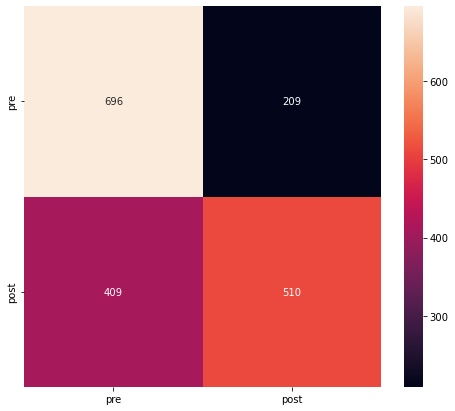

In [23]:
if evaluation:
  if not train:
    loss_function = nn.CrossEntropyLoss()
    print("loading best model for ",dataToProcess," ",mdl)
    inp_size=X_train.shape[1]
    out_size=y_train.shape[1]
    if mdl=="FCN":
      best_model = u.FCN(num_feature=inp_size, num_class=out_size).to(device)
    if mdl=="FCN_saliency":
      best_model = u.FCN_for_saliency(num_feature=inp_size, num_class=out_size).to(device)
    elif mdl=="CNN" or mdl=="CNN_saliency":
      s_max=False
      best_model=u.CNN(num_feature=inp_size, num_class=out_size).to(device)
    if force_traces_in_test: #some trace to be forced in test
      best_model.load_state_dict(torch.load(path+"\\models\\"+dataToProcess+"_bestmodel_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+"_traceForcedInTest.pt", map_location=map_location))
    else: #no trace to be forced in test
      best_model.load_state_dict(torch.load(path+"\\models\\"+dataToProcess+"_bestmodel_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".pt", map_location=map_location))

best_model.to(dev)

inputte=[]
labeltte=[]
outputte=[]
indexte=[]
if plot_model_hidden: # just for mdl=="FCN"
    outputte_after1layer=[]
    outputte_after2layer=[]
    outputte_after3layer=[]
    outputte_lastlayer=[]

confusion_matrix = torch.zeros(out_size, out_size)

best_model.eval()
with torch.no_grad():
    sum_loss_te = 0 
    for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)):
        inp = batch[0].to(dev)
        inp=inp[:,0:inp_size,:]
        inputte.append(inp)
        label = batch[1].to(dev)
        labeltte.append(label)
        indexte.append(batch[2].to(dev))
        if plot_model_hidden: 
          output_all = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size)
          output=output_all[0].sum(dim=1)
          outputte_after1layer.append(output_all[1])
          outputte_after2layer.append(output_all[2])
          outputte_after3layer.append(output_all[3])
          outputte_lastlayer.append(output_all[0])
        else:
          if mdl=="FCN":
            output = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size)[0]
            output=output.sum(dim=1)
          elif mdl=="FCN_saliency":
            output = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size)
          elif mdl=="CNN" or mdl=="CNN_saliency":          
            output = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size, softmax=s_max)[0]
        _, preds = torch.max(output, 1)
        _, classes = torch.max(label, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1               
        outputte.append(output)
        sum_loss_te += loss_function(output, label).item()*batch_size
    curr_te_loss = sum_loss_te/len(test_dl)
    print("curr_te_loss: ",curr_te_loss)
print("confusion_matrix",confusion_matrix)
# print("per-class accuracy: ",confusion_matrix.diag()/confusion_matrix.sum(1))
# print("Average accuracy: ",torch.mean(confusion_matrix.diag()/confusion_matrix.sum(1)))
print("per-class accuracy: ",[float("{:.2f}".format((t.item())*100)) for t in confusion_matrix.diag()/confusion_matrix.sum(1)]) # actually this is recall
print("Average accuracy: ",("{:.2f}".format((torch.mean(confusion_matrix.diag()/confusion_matrix.sum(1)).item())*100)), "%")
if num_classes==2:
  confusion_matrix_df = pd.DataFrame(confusion_matrix).rename(columns={0:'pre',1:'post'}, index={0:'pre',1:'post'})
else:
  cols={}
  for i in range(0,int(num_classes/2)):
    cols[i]='pre'+str(i)
  for i in range(int(num_classes/2),num_classes):
    cols[i]='post'+str(i)
  confusion_matrix_df = pd.DataFrame(confusion_matrix).rename(columns=cols, index=cols)
plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix_df, annot=True, fmt=".0f")
if save_img_out:
  img_name=path+"\\images\\"+dataToProcess+"_heatmap_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".jpg"
  plt.savefig(img_name,bbox_inches='tight')
plt.show()


In [26]:
confusion_matrix=confusion_matrix.numpy()
true_pos = np.diag(confusion_matrix)
false_pos = np.sum(confusion_matrix, axis=0) - true_pos
false_neg = np.sum(confusion_matrix, axis=1) - true_pos
true_neg = np.sum(confusion_matrix) - (false_pos + false_neg + true_pos)

accuracy = (true_pos + true_neg) / (true_pos + false_neg + true_neg + false_pos) # Accuracy Score = (TP + TN)/ (TP + FN + TN + FP). This works well for balanced data
precision = true_pos / (true_pos + false_pos) # Precision Score = TP / (TP + FP)
recall =true_pos / (true_pos + false_neg) # Recall Score = TP / (TP + FN)
f1_score=2*((precision*recall)/(precision+recall))# F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score). This works well for unbalanced data. It's the harmonic mean of recall and precision

print("accuracy: ",[float("{:.2f}".format(a*100)) for a in accuracy], " avg accuracy: ", "{:.2f}".format(sum(accuracy)/num_classes*100), "%")
print("precision: ",[float("{:.2f}".format(p*100)) for p in precision], " avg precision: ", "{:.2f}".format(sum(precision)/num_classes*100), "%")
print("recall: ",[float("{:.2f}".format(r*100)) for r in recall], " avg recall: ", "{:.2f}".format(sum(recall)/num_classes*100), "%")
print("f1_score: ",[float("{:.2f}".format(f1*100)) for f1 in f1_score], " avg f1_score: ", "{:.2f}".format(sum(f1_score)/num_classes*100), "%")

accuracy:  [66.12, 66.12]  avg accuracy:  66.12 %
precision:  [62.99, 70.93]  avg precision:  66.96 %
recall:  [76.91, 55.5]  avg recall:  66.20 %
f1_score:  [69.25, 62.27]  avg f1_score:  65.76 %


In [ ]:
# u.plot_input_allTrace_label(df,inputte,outputte,labeltte,indexte,inp_size,btch=20,start_wndw=1,end_wndw=20)

In [2]:
if plot_model_hidden:
  u.plot_hidden(df,inputte,outputte,outputte_after1layer,outputte_after2layer,outputte_after3layer,outputte_lastlayer,
                labeltte,indexte,inp_size,btch=0,start_wndw=1,end_wndw=20,plot_hid=True)

NameError: name 'plot_model_hidden' is not defined

In [27]:
if num_classes==2:
    tot,wrong,tot_pre,wrong_pre,tot_post,wrong_post,stationsDictTot, stationsDictWrong=u.performances(df,outputte,labeltte,indexte,batch_size)
    #distance_all,distance_of_wrong_pre, snr_of_all, snr_of_wrong_pre
    print("tot: ", tot," wrong: ",wrong)
    print("percentage of correctly classified: ",((tot-wrong)/tot*100),"%")
    print("tot pre: ", tot_pre," wrong pre: ",wrong_pre)
    print("percentage of pre correctly classified: ",((tot_pre-wrong_pre)/tot_pre*100),"%")
    print("tot post: ", tot_post," wrong post: ",wrong_post)
    print("percentage of post correctly classified: ",((tot_post-wrong_post)/tot_post*100),"%")

In [28]:
if num_classes==2:
    stationsDictCorrectPercentage = dict.fromkeys(stationsDictTot.keys(),0)
    print("Events per station in test set: ",stationsDictTot)
    print("Events wrongly classified: ",stationsDictWrong)
    for key in stationsDictCorrectPercentage:
        stationsDictCorrectPercentage[key]=(stationsDictTot[key]-stationsDictWrong[key])/stationsDictTot[key]*100
    print("Percentage of correctly classified events: ",stationsDictCorrectPercentage)
    plt.bar(list(stationsDictCorrectPercentage.keys()), stationsDictCorrectPercentage.values())
    plt.title('Performance per station')
    plt.xlabel('Station')
    plt.ylabel('Percentage of correctly classified')
    plt.show()


In [28]:
#%matplotlib qt
#%matplotlib inline
if mdl=="FCN_saliency" or mdl=="CNN_saliency":
  for idx, batch in enumerate(test_dl):#tqdm(enumerate(tr_dl), total=len(tr_dl)):
    inp = batch[0].to(device)
    inp=inp[:,0:inp_size,:]
    label = batch[1].to(device)
    u.show_saliency_maps(inp.float(), label.type(torch.int64), best_model, mdl, inp_size, s_max=s_max, show_spectrogram=False)
    break

In [ ]:
# if mini_dataset:
#   torch.save(best_model.state_dict(), path+"target_class"+target_class+"_bestmodel_for_explaination_mini_dataset.pt")
# else:
#   torch.save(best_model.state_dict(), path+"target_class"+target_class+"_whole_dataset_bestmodel.pt")

## Evaluate the model using external dataset

In [27]:
if traces_in_test=="NRCA_2000To2022":
    df_selected_traces_pre = pd.read_pickle(path+'dataframe\\dataframe_pre_2000to2016_NRCA.csv')
    df_selected_traces_post = pd.read_pickle(path+'dataframe\\dataframe_post_2017to2022_NRCA.csv')
    df_selected_traces=pd.concat([df_selected_traces_pre, df_selected_traces_post], ignore_index=True)
elif traces_in_test=="jan_aug_2017": 
    df_selected_traces= pd.read_pickle(path+'dataframe\\dataframe_post_jan_aug_2017_'+str(dataToProcess)+'.csv')
    # In dataframe_post_jan_aug_2017_NRCA.csv dataset we just have POST events
    # I have to add a fake PRE event, to avoid errors in plot functions
    # if num_classes==2:
    #     df_selected_traces=pd.concat([df_selected_traces,pd.DataFrame(np.repeat(df_selected_traces.iloc[[-1]].values,1,axis=0),columns=df_selected_traces.columns)]).reset_index(drop=True)
    #     df_selected_traces.iloc[-1]["label"]=[1, 0]
    # else:
    #     df_fake_pre=pd.DataFrame(np.repeat(df_selected_traces.iloc[[-1]].values,1,axis=0),columns=df_selected_traces.columns)
    #     df_fake_pre.iloc[-1]["label"]=[1, 0]
    #     frames_pre_selected_traces = u.frames_N_classes(df_fake_pre,num_classes, pre_or_post="pre")
    #     frames_post_selected_traces = u.frames_N_classes(df_selected_traces,num_classes, pre_or_post="post")
    #     df_selected_traces=pd.concat([pd.concat(frames_pre_selected_traces),pd.concat(frames_post_selected_traces)], ignore_index=True)
    #     df_selected_traces=df_selected_traces.drop(['index'],axis=1)#.reset_index(drop=True)

Events in train dataset:  0
Events in validation dataset:  0
Events in test dataset:  6847
X_train.shape:  (0, 2500, 3)
y_train.shape:  (0, 2)
index_train.shape:  (0, 1)
X_val.shape:  (0, 2500, 3)
y_val.shape:  (0, 2)
index_val.shape:  (0, 1)
X_test.shape:  (6847, 2500, 3)
y_test.shape:  (6847, 2)
index_test.shape:  (6847, 1)


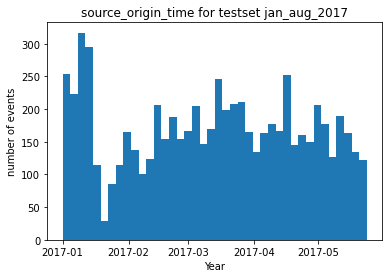

  0%|          | 0/213 [00:00<?, ?it/s]

curr_te_loss:  35.79518423841593
confusion_matrix tensor([[   0.,    0.],
        [4054., 2762.]])
per-class accuracy:  [nan, 40.52]
Average accuracy:  nan %


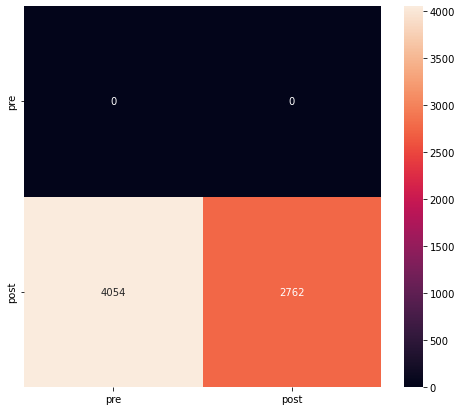

In [28]:
force_traces_in_test=df_selected_traces["trace_name"].values.tolist()
df_selected_traces['source_origin_time'] = df_selected_traces['source_origin_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
df_selected_traces['TTF'] = df_selected_traces.apply (lambda row: u.add_TTF_in_sec(row), axis=1)
df_selected_traces, X_train_selected_traces, y_train_selected_traces, index_train_selected_traces, X_val_selected_traces, y_val_selected_traces, index_val_selected_traces, X_test_selected_traces, y_test_selected_traces, index_test_selected_traces=u.train_val_test_split(df_selected_traces, train_percentage=0, val_percentage=0, test_percentage=1,force_in_test=force_traces_in_test, plot_hist=False)
plt.hist(df_selected_traces['source_origin_time'], bins=40)
plt.title('source_origin_time for testset '+traces_in_test)
plt.xlabel('Year')
plt.ylabel('number of events')
plt.show()
# tr_dl_selected_traces = u.create_dataloader(X=X_train_selected_traces, y=y_train_selected_traces, index=index_train_selected_traces,target_dataset="train_dataset", batch_size=batch_size)
# val_dl_selected_traces = u.create_dataloader(X=X_val_selected_traces, y=y_val_selected_traces, index=index_val_selected_traces,target_dataset="val_dataset", batch_size=batch_size)
test_dl_selected_traces = u.create_dataloader(X=X_test_selected_traces, y=y_test_selected_traces, index=index_test_selected_traces,target_dataset="test_dataset", batch_size=batch_size)

inputte_selected_traces=[]
labeltte_selected_traces=[]
outputte_selected_traces=[]
indexte_selected_traces=[]
if plot_model_hidden: # just for mdl=="FCN"
    outputte_after1layer=[]
    outputte_after2layer=[]
    outputte_after3layer=[]
    outputte_lastlayer=[]

confusion_matrix_selected_traces = torch.zeros(out_size, out_size)

best_model.eval()
with torch.no_grad():
    sum_loss_te_selected_traces = 0 
    for idx, batch in tqdm(enumerate(test_dl_selected_traces), total=len(test_dl_selected_traces)):
        inp = batch[0].to(dev)
        inp=inp[:,0:inp_size,:]
        inputte_selected_traces.append(inp)
        label = batch[1].to(dev)
        labeltte_selected_traces.append(label)
        indexte_selected_traces.append(batch[2].to(dev))
        if plot_model_hidden: 
          output_all = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size)
          output=output_all[0].sum(dim=1)
          outputte_after1layer.append(output_all[1])
          outputte_after2layer.append(output_all[2])
          outputte_after3layer.append(output_all[3])
          outputte_lastlayer.append(output_all[0])
        else:
          if mdl=="FCN":
            output = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size)[0]
            output=output.sum(dim=1)
          elif mdl=="FCN_saliency":
            output = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size)
          elif mdl=="CNN" or mdl=="CNN_saliency":          
            output = best_model(inp.float(), batch_size=batch_size, steps_in=inp_size, softmax=s_max)[0]
        _, preds_selected_traces = torch.max(output, 1)
        _, classes_selected_traces = torch.max(label, 1)
        for t, p in zip(classes_selected_traces.view(-1), preds_selected_traces.view(-1)):
            confusion_matrix_selected_traces[t.long(), p.long()] += 1               
        outputte_selected_traces.append(output)
        sum_loss_te_selected_traces += loss_function(output, label).item()*batch_size
    curr_te_loss_selected_traces = sum_loss_te_selected_traces/len(test_dl_selected_traces)
    print("curr_te_loss: ",curr_te_loss_selected_traces)
print("confusion_matrix",confusion_matrix_selected_traces)
# print("per-class accuracy: ",confusion_matrix.diag()/confusion_matrix.sum(1))
# print("Average accuracy: ",torch.mean(confusion_matrix.diag()/confusion_matrix.sum(1)))
print("per-class accuracy: ",[float("{:.2f}".format((t.item())*100)) for t in confusion_matrix_selected_traces.diag()/confusion_matrix_selected_traces.sum(1)]) # actually this is recall
print("Average accuracy: ",("{:.2f}".format((torch.mean(confusion_matrix_selected_traces.diag()/confusion_matrix_selected_traces.sum(1)).item())*100)), "%")
if num_classes==2:
  confusion_matrix_df_selected_traces = pd.DataFrame(confusion_matrix_selected_traces).rename(columns={0:'pre',1:'post'}, index={0:'pre',1:'post'})
else:
  cols={}
  for i in range(0,int(num_classes/2)):
    cols[i]='pre'+str(i)
  for i in range(int(num_classes/2),num_classes):
    cols[i]='post'+str(i)
  confusion_matrix_df_selected_traces = pd.DataFrame(confusion_matrix_selected_traces).rename(columns=cols, index=cols)
plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix_df_selected_traces, annot=True, fmt=".0f")
# if save_img_out:
#   img_name=path+"\\images\\"+dataToProcess+"_heatmap_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".jpg"
#   plt.savefig(img_name,bbox_inches='tight')
plt.show()


In [ ]:
# #confusion_matrix_df_selected_traces["pre"]["pre"]=1
# #confusion_matrix_df_selected_traces["post"]["pre"]=1
# print("per-class accuracy: ",[float("{:.2f}".format((t.item())*100)) for t in confusion_matrix_selected_traces.diag()/confusion_matrix_selected_traces.sum(1)]) # actually this is recall
# print("Average accuracy: ",("{:.2f}".format((torch.mean(confusion_matrix_selected_traces.diag()/confusion_matrix_selected_traces.sum(1)).item())*100)), "%")
# plt.figure(figsize=(8,7))
# sns.heatmap(confusion_matrix_df_selected_traces, annot=True, fmt=".0f")
# plt.show()


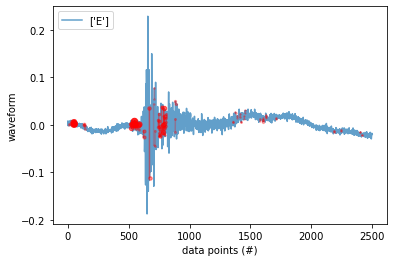

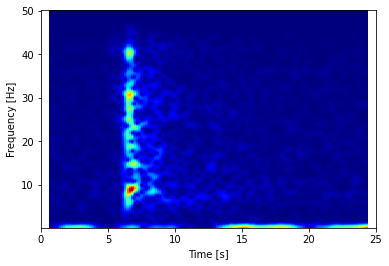

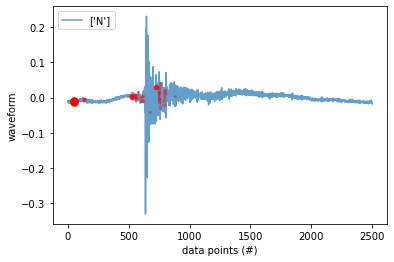

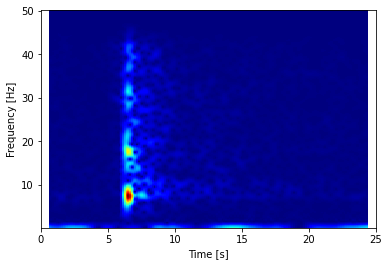

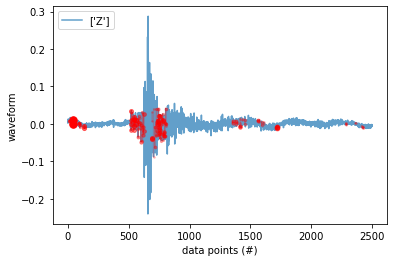

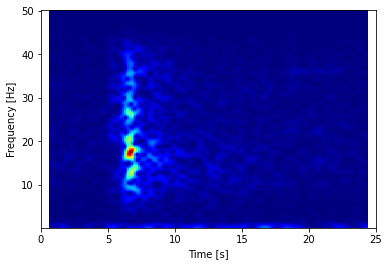

output= tensor([ 4.1194, -4.0807], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


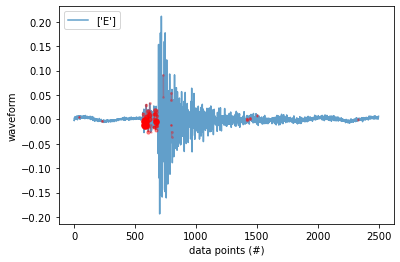

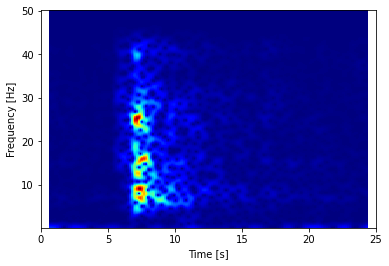

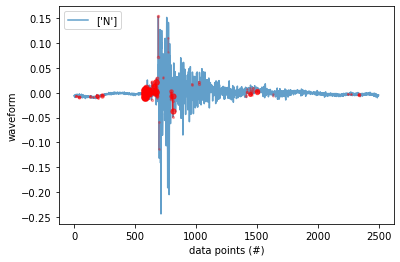

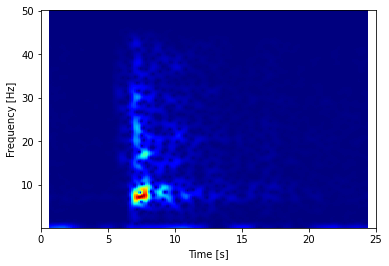

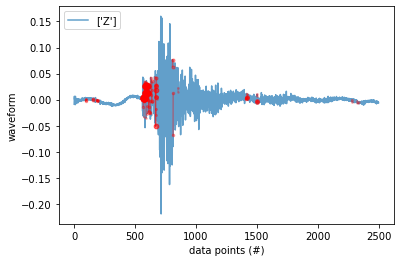

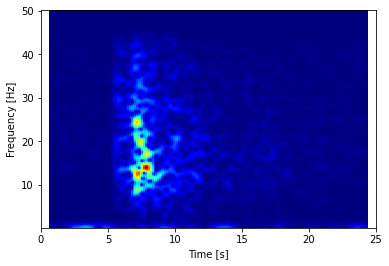

output= tensor([ 1.3871, -1.3750], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


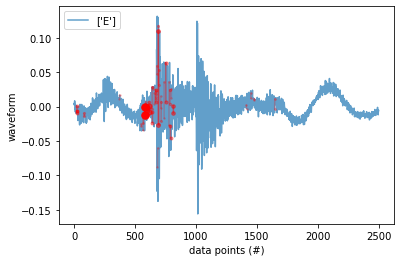

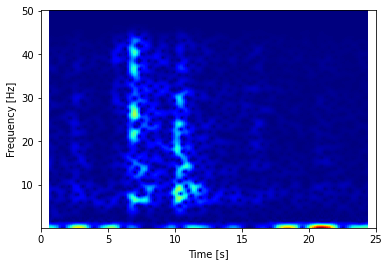

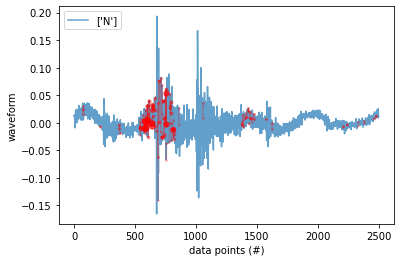

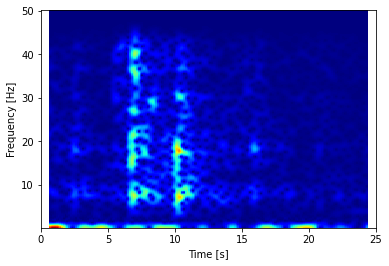

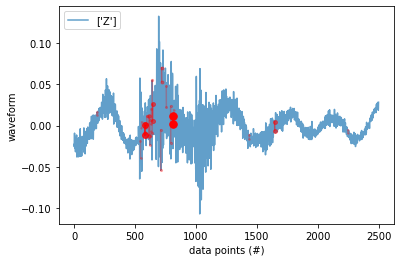

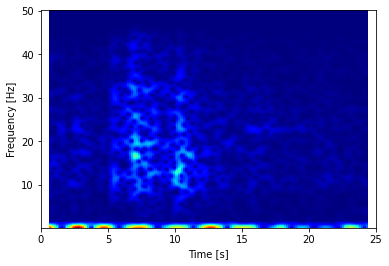

output= tensor([-4.5317,  4.4959], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([0., 1.])


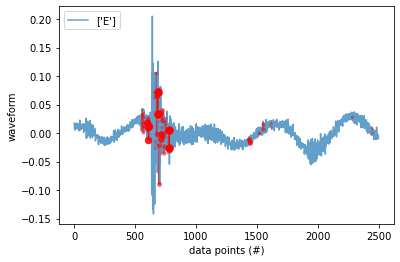

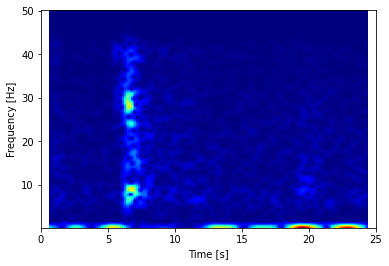

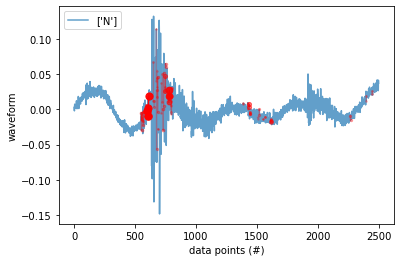

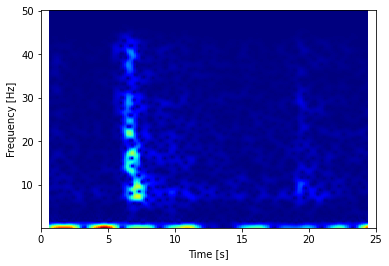

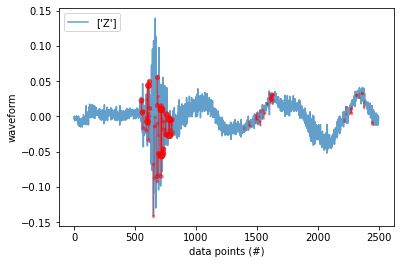

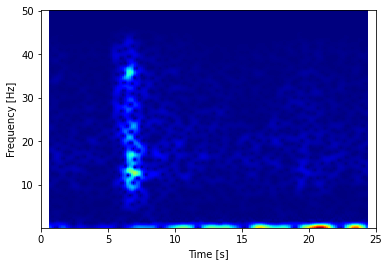

output= tensor([ 4.1503, -4.1107], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


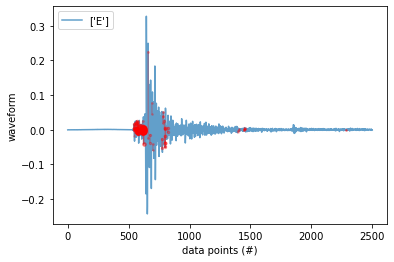

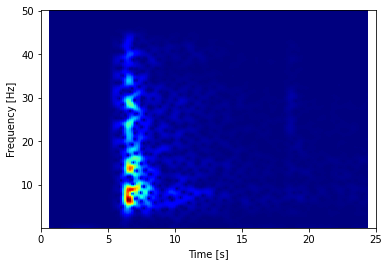

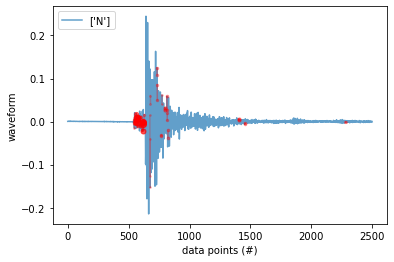

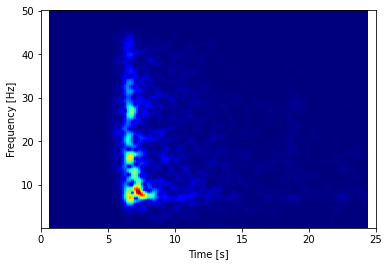

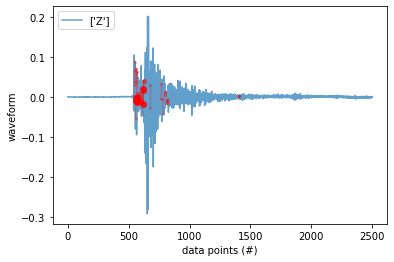

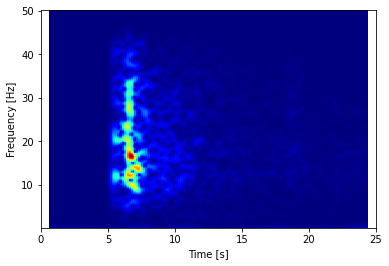

output= tensor([ 0.8537, -0.8457], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


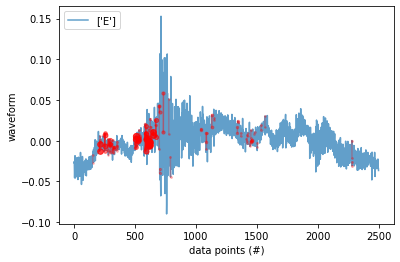

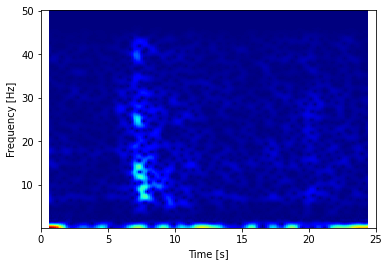

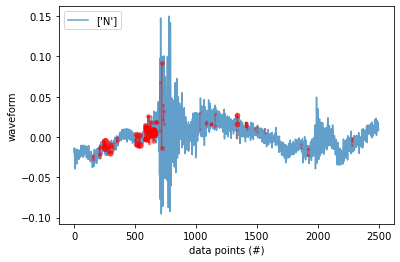

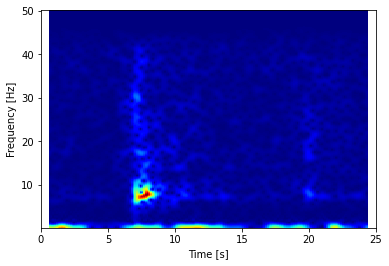

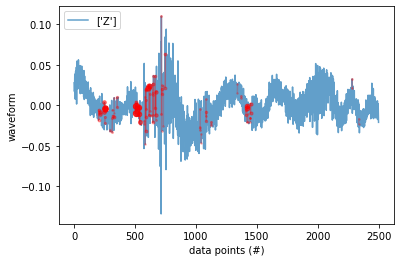

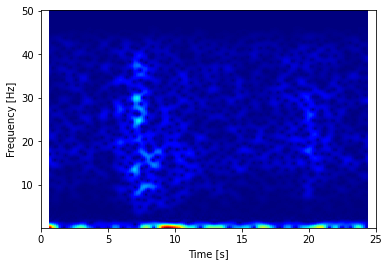

output= tensor([ 2.2090, -2.1882], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


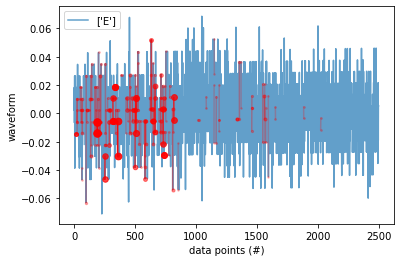

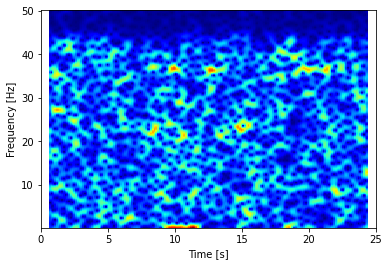

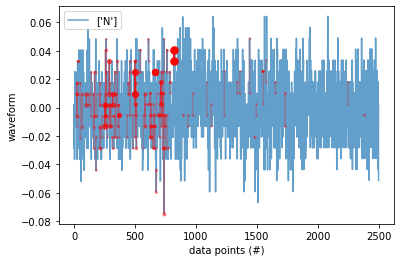

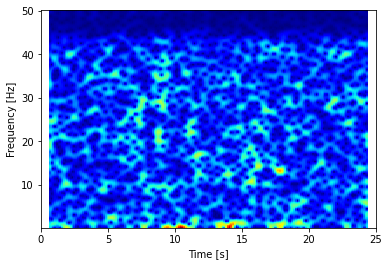

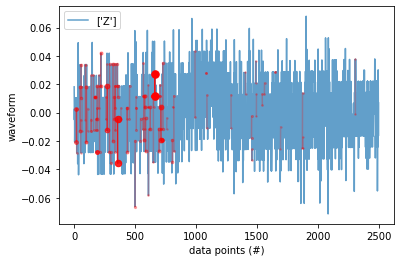

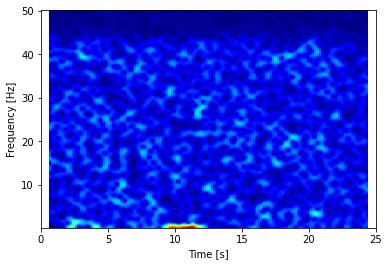

output= tensor([ 4.3437, -4.2925], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


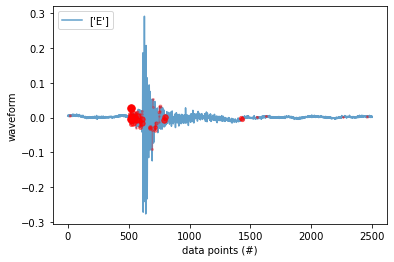

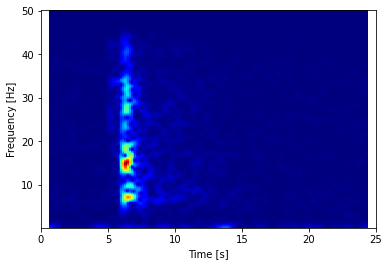

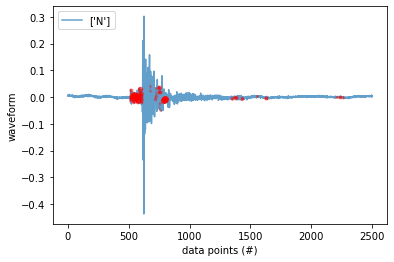

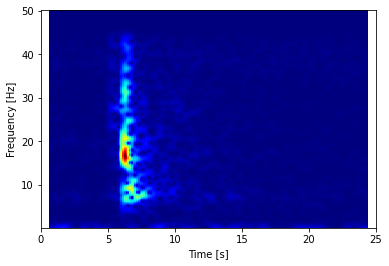

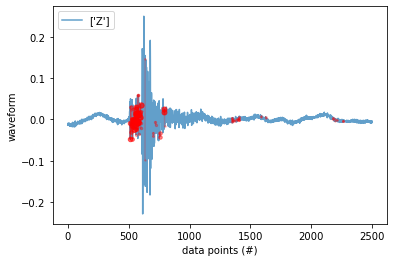

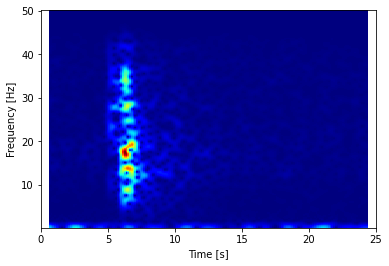

output= tensor([ 0.8563, -0.8457], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


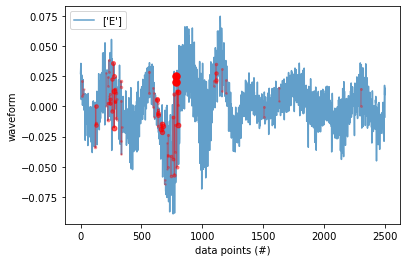

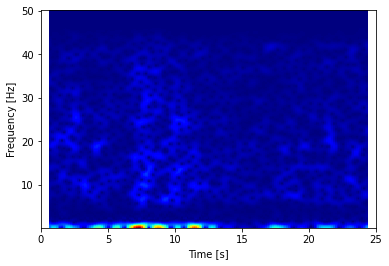

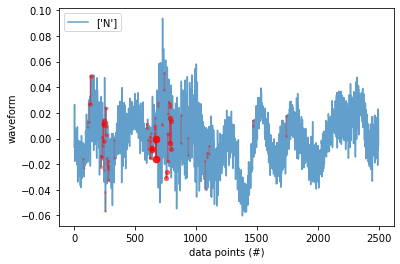

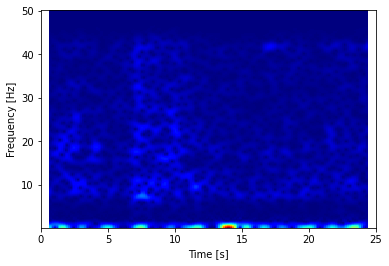

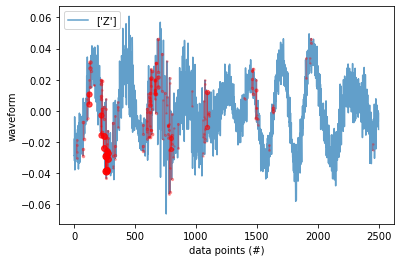

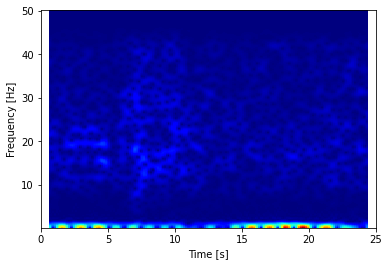

output= tensor([-0.4612,  0.4580], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([0., 1.])


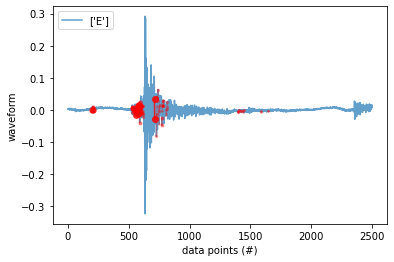

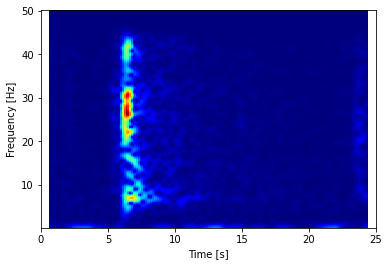

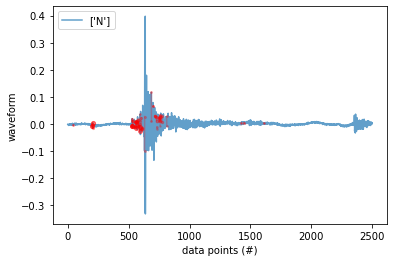

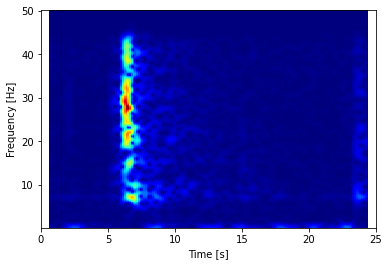

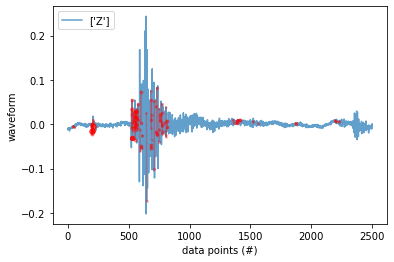

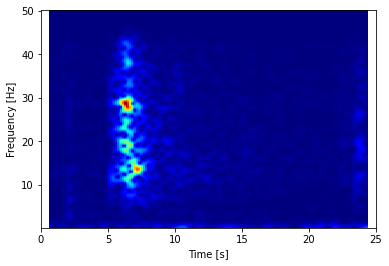

output= tensor([ 0.1906, -0.1842], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


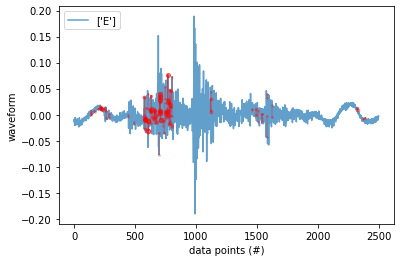

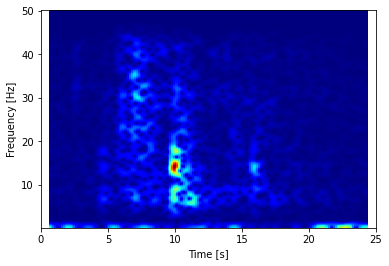

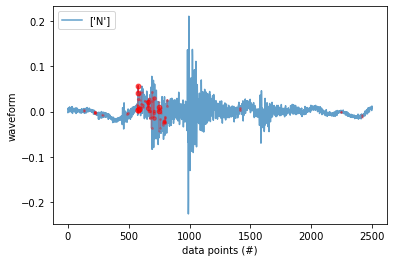

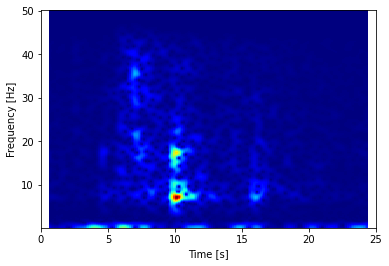

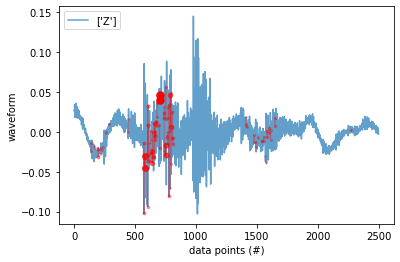

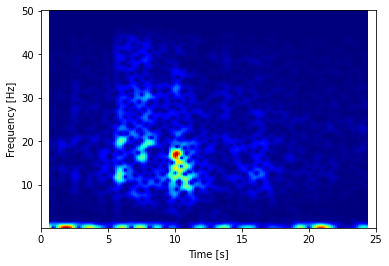

output= tensor([-5.1846,  5.1434], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([0., 1.])


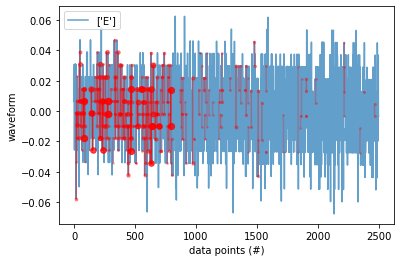

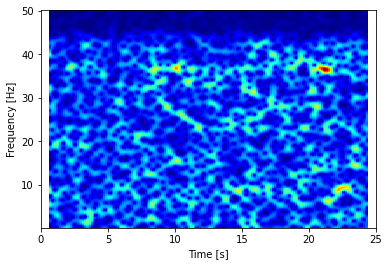

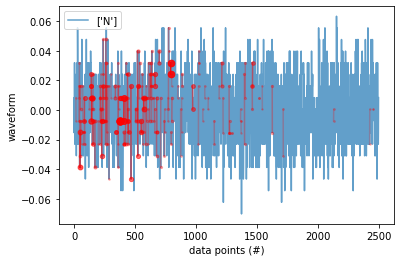

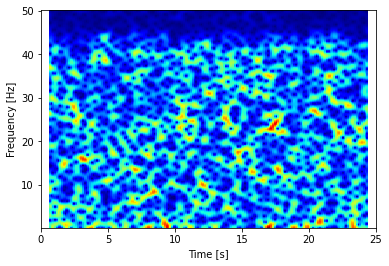

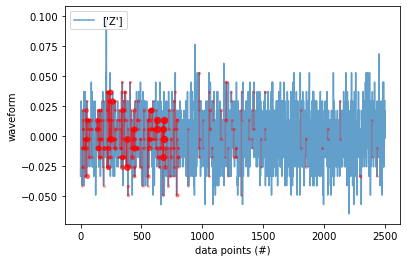

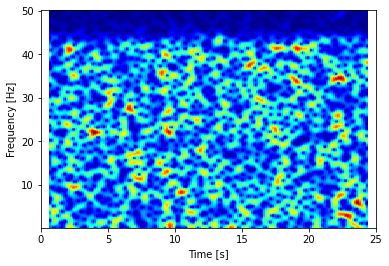

output= tensor([ 7.1423, -7.0623], grad_fn=<SelectBackward0>)
label= tensor([0, 1])
binary output= tensor([1., 0.])


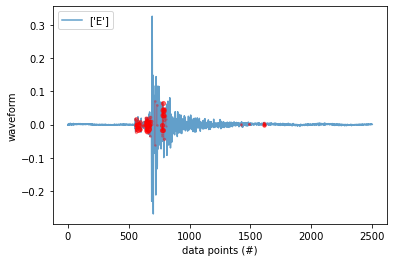

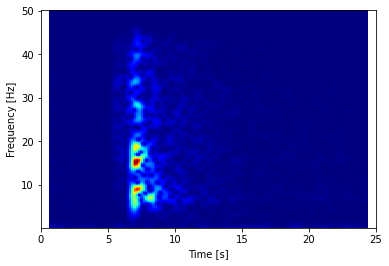

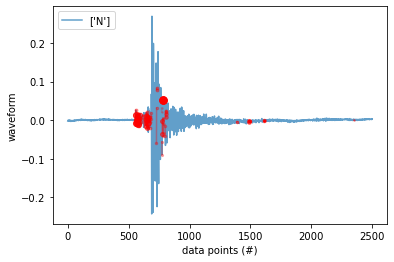

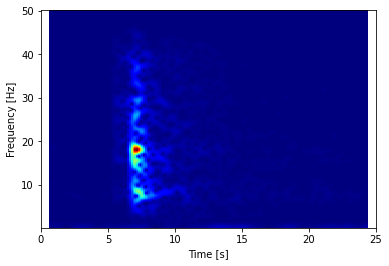

KeyboardInterrupt: 

In [ ]:
if mdl=="FCN_saliency" or mdl=="CNN_saliency":
  for idx, batch in enumerate(test_dl_selected_traces):#tqdm(enumerate(tr_dl), total=len(tr_dl)):
    inp = batch[0].to(device)
    inp=inp[:,0:inp_size,:]
    label = batch[1].to(device)
    u.show_saliency_maps(inp.float(), label.type(torch.int64), best_model, mdl, inp_size, s_max=s_max, show_spectrogram=True)
    break

In [37]:
# if num_classes==2:
#     print("first event in pre is on ",df_selected_traces_pre['trace_start_time'].min()," last event in pre is on ",df_selected_traces_pre['trace_start_time'].max())
#     print("first event in post is on ",df_selected_traces_post['trace_start_time'].min()," last event in post is on ",df_selected_traces_post['trace_start_time'].max())

#     plt.figure(figsize=(20,7))
#     plt.hist(df_selected_traces_pre['trace_start_time'], label='pre', bins=20)
#     plt.hist(df_selected_traces_post['trace_start_time'], label='post', bins=20)
#     plt.legend(loc='upper right')
#     plt.show()

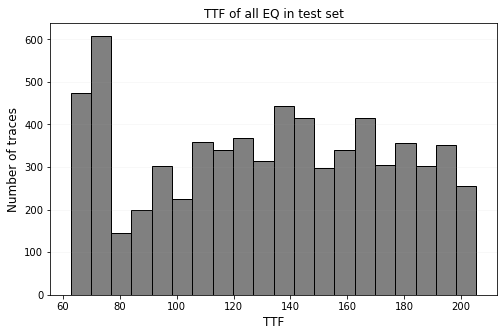

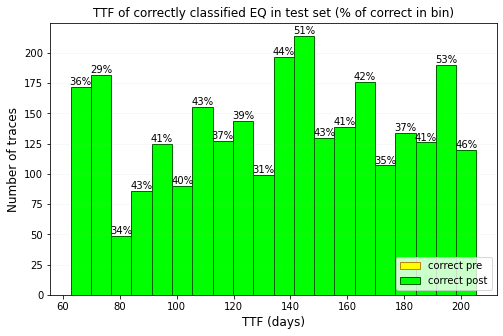

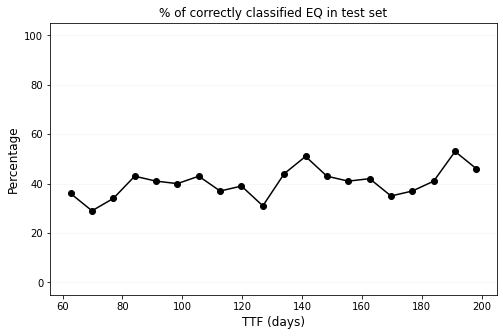

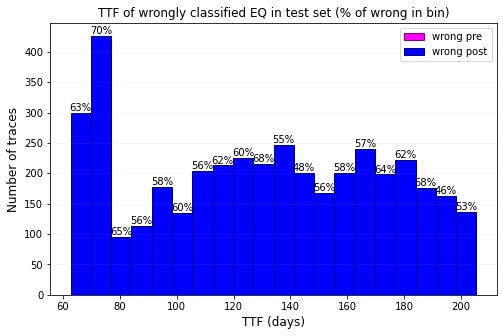

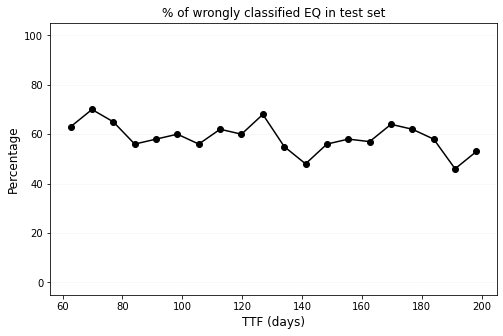

In [30]:
output_testDF_selected_traces=u.create_output_testDF(df_selected_traces, outputte_selected_traces, labeltte_selected_traces, indexte_selected_traces, batch_size=32)
# In dataframe_post_jan_aug_2017_NRCA.csv dataset we just have POST events
# I have to add a fake PRE event, to avoid errors in plot functions
idx_fake=-1
for index, row in output_testDF_selected_traces.iterrows():
    if row['binary_output']==[0, 1]:
        idx_fake=index
        break
df_fake_pre=pd.DataFrame(np.repeat(output_testDF_selected_traces.loc[[idx_fake]].values,1,axis=0),columns=output_testDF_selected_traces.columns)
df_fake_pre.at[0,'label']=[1, 0]
output_testDF_selected_traces=pd.concat([df_fake_pre,output_testDF_selected_traces], ignore_index=True)
output_testDF_selected_traces.head()

# if num_classes==2:
#     img_name=path+"\\images\\"+dataToProcess+"_locationOfEQ_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".jpg"
#     u.PlotEventsWithStations(dataToProcess,mdl,output_testDF_selected_traces,save_img_out, img_name)
if num_classes==2:
    u.PlotHistOfFeature(output_testDF_selected_traces,dataToProcess,mdl, seed, num_classes, feature='TTF', hist_bins=20, plot_together=True, plot_percentage=True,save_img_out=save_img_out,path=path, TTF_measure="days") 


In [28]:
# This is an analysis for TTF=[80, 94] days, that in seconds are (times 86400): [6912000, 8121600]. 
# This is because we have poor performance in this range when traces_in_test="jan_aug_2017" and dataToProcess=="NRCA"

if traces_in_test=="jan_aug_2017" and dataToProcess=="NRCA":
    output_testDF_selected_traces_selectedTTF= output_testDF_selected_traces[(output_testDF_selected_traces['TTF'] >= 6912000) & (output_testDF_selected_traces['TTF'] <= 8121600)]
    # In dataframe_post_jan_aug_2017_NRCA.csv dataset we just have POST events, as before let's add a fake PRE event, to avoid errors in plot functions
    # We select the index in a way that the output from the model is correct
    idx_fake=-1
    for index, row in output_testDF_selected_traces_selectedTTF.iterrows():
        if row['binary_output']==[0, 1]:
            idx_fake=index
            break
    df_fake_pre=pd.DataFrame(np.repeat(output_testDF_selected_traces_selectedTTF.loc[[idx_fake]].values,1,axis=0),columns=output_testDF_selected_traces_selectedTTF.columns)
    df_fake_pre.at[0,'label']=[1, 0]
    output_testDF_selected_traces_selectedTTF=pd.concat([df_fake_pre,output_testDF_selected_traces_selectedTTF], ignore_index=True)
    if num_classes==2:
        img_name=path+"\\images\\"+dataToProcess+"_locationOfEQ_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".jpg"
        u.PlotEventsWithStations(dataToProcess,mdl,output_testDF_selected_traces_selectedTTF,save_img_out, img_name)


### Make statistics and plot about the dataset

In [24]:
output_testDF=u.create_output_testDF(df, outputte, labeltte, indexte, batch_size=32)

# for index, row in output_testDF.iterrows():
#     if row['binary_output']==row['label']:
#         print("row ",index," is predicted correctly")
#     else:
#         print("row ",index," is predicted wrongly")
#         break
output_testDF['weekday']=output_testDF.apply (lambda row: row.source_origin_time.weekday(), axis=1) # Monday == 0 … Sunday == 6.
output_testDF.head()

,trace_name,output,binary_output,E_channel,N_channel,Z_channel,label,trace_start_time,network_code,receiver_name,...,source_depth_km,source_latitude,source_longitude,source_magnitude_type,source_magnitude,source_origin_time,p_travel_sec,TTF,index,weekday
0,T1244.IV.100304593_EV,"[0.59344155, -0.5865301]","[1, 0]","[64.87527483011598, 28.876553338760488, -59.12...","[125.21128239351742, 103.21206018887409, 73.21...","[-89.42483246509549, -46.42496664950326, -81.4...","[0, 1]",2016-11-28 10:35:02.030,IV,T1244,...,6.092,42.82269,13.16788,Mw,1.33,2016-11-28 10:35:04,3.03,2516087.0,5345.0,0
1,T1244.IV.100095043_EV,"[0.2442903, -0.22752278]","[1, 0]","[-1891.6686629904393, -976.6728279400951, -108...","[-973.1420880089208, -1297.1172034468705, -135...","[979.8369362087301, 578.8306340328138, 857.824...","[0, 1]",2016-10-30 14:27:52.550,IV,T1244,...,3.964,42.82807,13.19850,Mw,2.70,2016-10-30 14:27:55,2.55,24458.0,5386.0,6
2,T1244.IV.100041685_EV,"[-0.8084604, 0.80730176]","[0, 1]","[49.25350243595602, 44.25365437211201, 30.2538...","[-12.32049050883245, -8.320665303950364, -22.3...","[6.34772853448554, -5.652974118553971, 8.34632...","[1, 0]",2016-10-20 17:34:03.170,IV,T1244,...,3.687,42.88550,13.13964,Mw,0.92,2016-10-20 17:34:04,4.17,-828373.0,251.0,3
3,T1244.IV.100553491_EV,"[-2.4836764, 2.420118]","[0, 1]","[-11.347190620154805, -10.347940296687085, 5.6...","[19.01053103938284, 4.009344845658859, -3.9918...","[8.568537093555847, 1.5682837832732446, 10.568...","[0, 1]",2016-12-05 11:35:48.510,IV,T1244,...,2.333,42.92993,13.08704,Mw,0.99,2016-12-05 11:35:48,5.51,3124531.0,4486.0,0
4,T1244.IV.100721661_EV,"[0.3970887, -0.35099953]","[1, 0]","[27.285644015774835, 13.286274996763751, -10.7...","[-5.57527396715173, -6.575013668009987, 0.4252...","[-16.48471354863335, -17.485760403944028, -11....","[1, 0]",2016-09-23 19:24:35.410,IV,T1244,...,3.040,42.90088,13.14045,Mw,0.63,2016-09-23 19:24:36,4.41,-3154541.0,884.0,4


In [26]:
# if force_traces_in_test: #some trace to be forced in test
#     file_name_save=path+"\\output_testDF\\output_testDF_"+dataToProcess+"_model_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+"_traceForcedInTest.csv"
# else: #no trace to be forced in test
#     file_name_save=path+"\\output_testDF\\output_testDF_"+dataToProcess+"_model_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".csv"
# output_testDF.to_pickle(file_name_save)

# output_testDF_read=pd.read_pickle(path+"\\output_testDF\\output_testDF_"+dataToProcess+"_model_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+"_traceForcedInTest.csv")
# output_testDF_read

In [36]:
# for i in force_traces_in_test:
#     if output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["trace_start_time"].values[0][:4]=="2017":
#         plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["E_channel"].values[0], label=['E'])
#         plt.xlabel('time (s)')
#         plt.ylabel('waveform')
#         plt.legend(loc='lower left')
#         plt.show()
#         plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["N_channel"].values[0], label=['N'])
#         plt.xlabel('time (s)')
#         plt.ylabel('waveform')
#         plt.legend(loc='lower left')
#         plt.show()
#         plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["Z_channel"].values[0], label=['Z'])
#         plt.xlabel('time (s)')
#         plt.ylabel('waveform')
#         plt.legend(loc='lower left')
#         plt.show()
#         print(i)
#         print('Output',output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["output"])
#         print('Output one_hot',output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["binary_output"])
#         print('Label',output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["label"])

In [25]:
if traces_in_test=="NRCA_2000To2022":
    for i in force_traces_in_test:
        #if output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["trace_start_time"].values[0][:4]=="2017":
        plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["E_channel"].values[0], label=['E'])
        plt.xlabel('time (s)')
        plt.ylabel('waveform')
        plt.legend(loc='lower left')
        plt.show()
        plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["N_channel"].values[0], label=['N'])
        plt.xlabel('time (s)')
        plt.ylabel('waveform')
        plt.legend(loc='lower left')
        plt.show()
        plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["Z_channel"].values[0], label=['Z'])
        plt.xlabel('time (s)')
        plt.ylabel('waveform')
        plt.legend(loc='lower left')
        plt.show()
        print(i)
        print('Output',output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["output"])
        print('Output one_hot',output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["binary_output"])
        print('Label',output_testDF_selected_traces.loc[output_testDF_selected_traces['trace_name'] == i]["label"])

else:    
    for i in force_traces_in_test:
        plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF.loc[output_testDF['trace_name'] == i]["E_channel"].values[0], label=['E'])
        plt.xlabel('time (s)')
        plt.ylabel('waveform')
        plt.legend(loc='lower left')
        plt.show()
        plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF.loc[output_testDF['trace_name'] == i]["N_channel"].values[0], label=['N'])
        plt.xlabel('time (s)')
        plt.ylabel('waveform')
        plt.legend(loc='lower left')
        plt.show()
        plt.plot([r*0.01 for r in range(0,inp_size)], output_testDF.loc[output_testDF['trace_name'] == i]["Z_channel"].values[0], label=['Z'])
        plt.xlabel('time (s)')
        plt.ylabel('waveform')
        plt.legend(loc='lower left')
        plt.show()
        print(i)
        print('Output',output_testDF.loc[output_testDF['trace_name'] == i]["output"])
        print('Output one_hot',output_testDF.loc[output_testDF['trace_name'] == i]["binary_output"])
        print('Label',output_testDF.loc[output_testDF['trace_name'] == i]["label"])


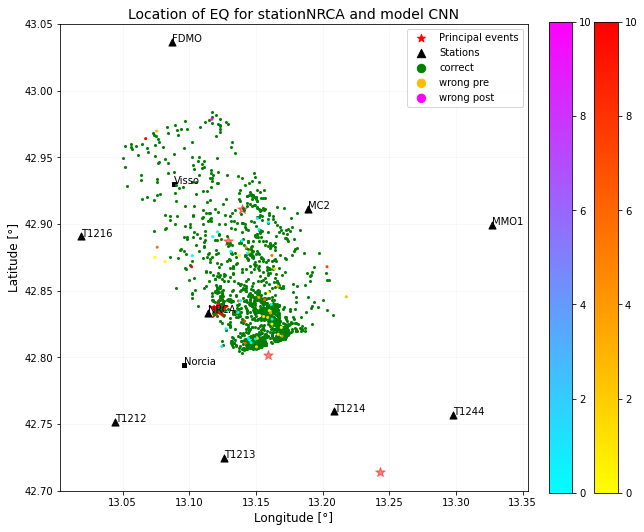

In [24]:
#magnit_all,magnit_of_wrong_pre, magnit_of_wrong_post=u.feature_tot_wrong("source_magnitude",df,outputte,labeltte,indexte,batch_size)
if num_classes==2:
    img_name=path+"\\images\\"+dataToProcess+"_locationOfEQ_"+mdl+"_seed"+str(seed)+"_classes"+str(num_classes)+".jpg"
    u.PlotEventsWithStations(dataToProcess,mdl,output_testDF,save_img_out, img_name)

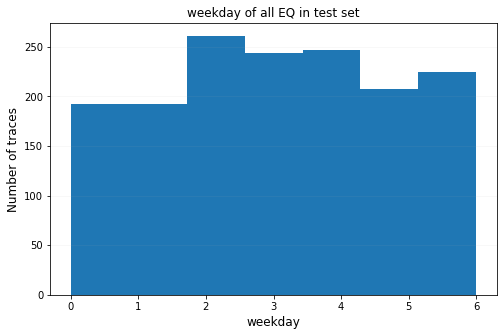

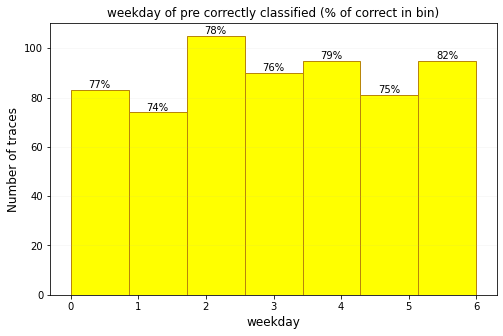

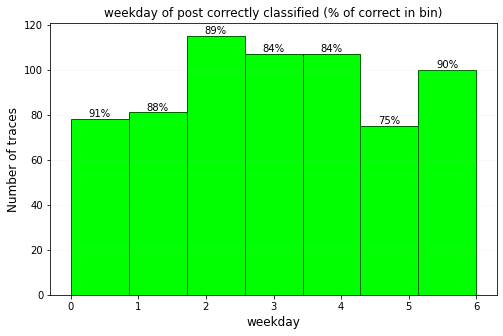

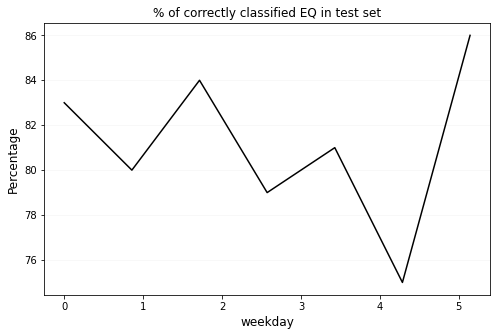

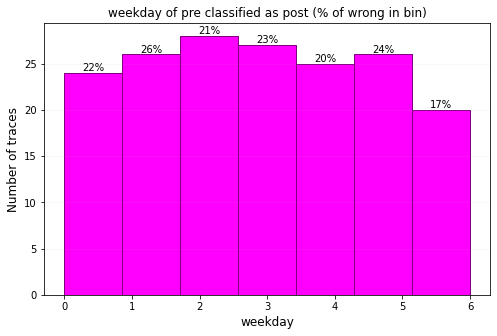

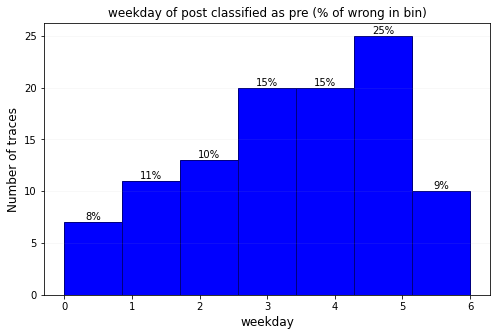

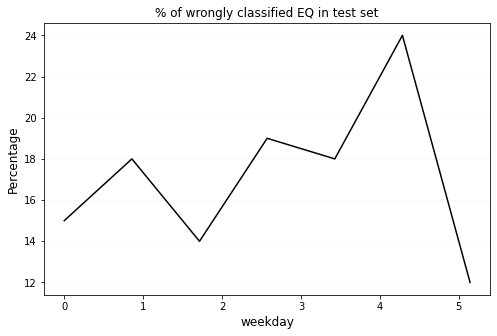

In [25]:
if num_classes==2:
    u.PlotHistOfFeature(output_testDF,dataToProcess,mdl, seed, num_classes, feature='weekday', hist_bins=7, plot_together=False, plot_percentage=True,save_img_out=save_img_out,path=path, TTF_measure="no") 